In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import io
from google.colab import files
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Load data and cleaning

In [ ]:
# upload file to colab
uploaded = files.upload()
df = pd.read_csv('SP600_AdjClose_Volume_Return.csv')
df.head()

Saving SP600_AdjClose_Volume_Return.csv to SP600_AdjClose_Volume_Return (4).csv


,Date,Adj Close,Volume,Ticker,Return
0,2019-09-30,150.984787,982800,AAP,NaN
1,2019-10-01,152.710083,1086300,AAP,0.011427
2,2019-10-02,148.757477,975400,AAP,-0.025883
3,2019-10-03,145.927643,918100,AAP,-0.019023
4,2019-10-04,146.000702,749000,AAP,0.000501


preprocessing

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

window_size = 10  # 窗口大小
threshold_factor = 2  # 异常检测的标准差倍数，可根据需求调整

# 特征工程
df['Volume_Rolling_Mean'] = df['Volume'].rolling(window=window_size).mean()
df['Volume_Rolling_Std'] = df['Volume'].rolling(window=window_size).std()
df['Price_Volume_Ratio'] = df['Adj Close'] / df['Volume']
df['Volume_Change'] = df['Volume'].pct_change()
df['Price_Volume_Change'] = df['Price_Volume_Ratio'].pct_change()

# 根据滚动均值和标准差标记异常
df['Volume_Anomaly'] = np.where(
    (np.abs(df['Volume'] - df['Volume_Rolling_Mean']) > threshold_factor * df['Volume_Rolling_Std']),
    1,
    0
)



# 数据清洗（改进部分）
# 将 inf 和 -inf 替换为合适的最大值或最小值
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# 填充数值列的缺失值为均值
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# 填充非数值列的缺失值为空字符串
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna("")





# 特征和目标
features = ['Volume_Rolling_Mean', 'Volume_Rolling_Std', 'Price_Volume_Ratio',
            'Volume_Change', 'Price_Volume_Change']
target = 'Volume_Anomaly'  # 使用生成的 Volume_Anomaly 列作为目标

# 数据标准化
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


# 统计 Volume_Anomaly 的分布
anomaly_counts = df['Volume_Anomaly'].value_counts()
print("Volume_Anomaly 分布:\n", anomaly_counts)

# 查看异常点的比例
anomaly_ratio = anomaly_counts[1] / anomaly_counts.sum() * 100
print(f"异常点比例: {anomaly_ratio:.2f}%")





Volume_Anomaly 分布:
 Volume_Anomaly
0    689048
1     45542
Name: count, dtype: int64
异常点比例: 6.20%


In [ ]:
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# LightGBM 分类模型（直接使用指定参数）
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',  # 二分类任务
    learning_rate=0.05,  # 可根据需要调整
    num_leaves=31,
    max_depth=-1,
    n_estimators=200,  # 可根据需要调整
    metric='auc'
)

# 训练模型
lgb_model.fit(X_train, y_train)

# 预测
y_pred = lgb_model.predict(X_test)

# 评估分类模型的性能
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 输出分类报告
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 36514, number of negative: 551158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 587672, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062133 -> initscore=-2.714326
[LightGBM] [Info] Start training from score -2.714326
Accuracy: 0.9531
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    137890
           1       0.73      0.38      0.50      9028

    accuracy                           0.95    146918
   macro avg       0.84      0.69      0.74    146918
weighted avg       0.95      0.95      0.95    146918



<ipython-input-50-5d36365ab6d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volume_aap['Predicted_Anomaly'] = y_pred_volume_aap


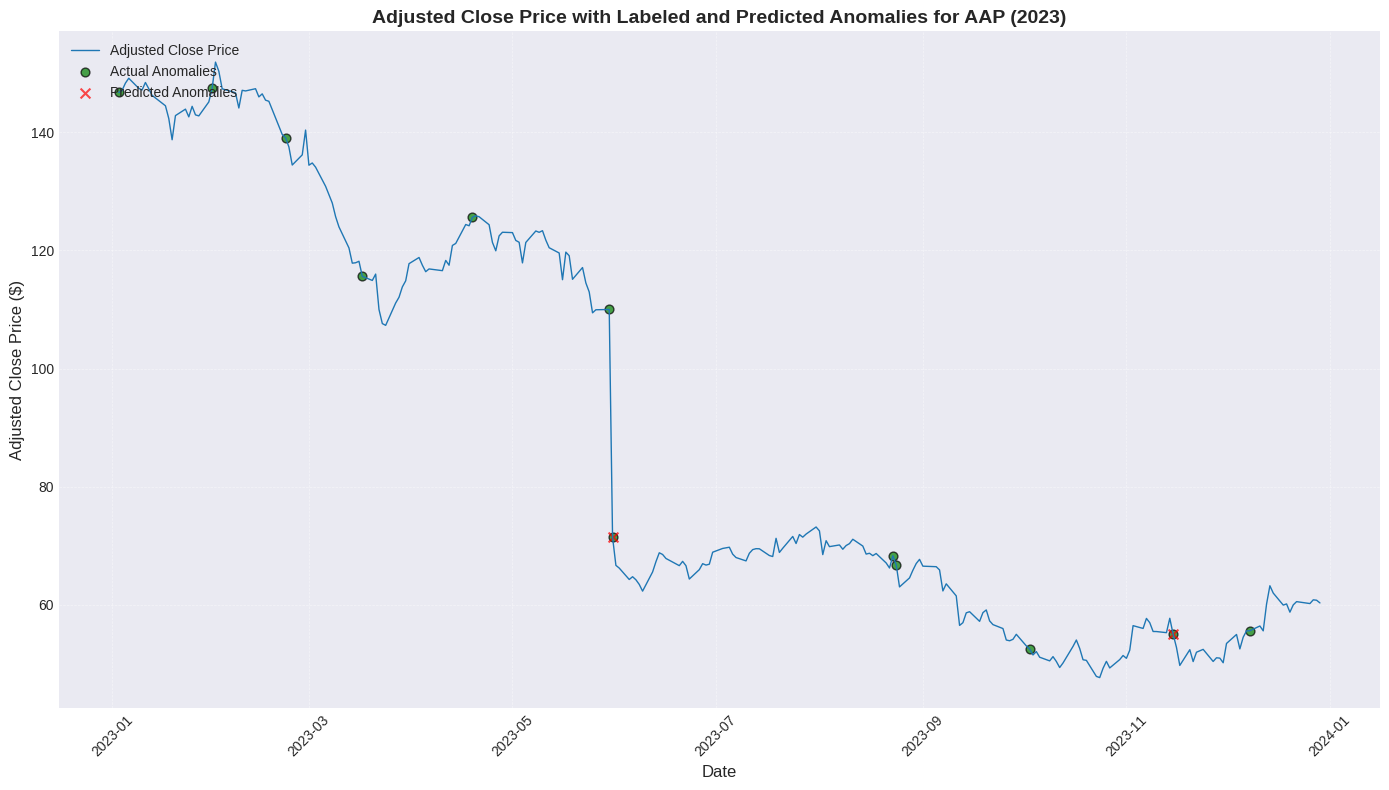

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 确保 'Date' 列为日期格式
df['Date'] = pd.to_datetime(df['Date'])

# 过滤数据集，选择特定股票（例如 'AAP'）和年份（如 2023）
df_volume_aap = df[(df['Ticker'] == 'AAP') & (df['Date'].dt.year == 2023)]

# 检查是否有数据
if df_volume_aap.empty:
    raise ValueError("No data available for the specified Ticker ('AAP') and year (2023).")

# 准备特征数据
X_volume_aap = df_volume_aap[features].values

# 填充或处理 NaN 数据，避免空值
X_volume_aap = np.nan_to_num(X_volume_aap)

# 使用训练好的模型预测异常点
y_pred_volume_aap = lgb_model.predict(X_volume_aap)

# 添加预测结果到 DataFrame 中
df_volume_aap['Predicted_Anomaly'] = y_pred_volume_aap

# 创建可视化图表，展示实际数据与预测结果
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# 绘制 Volume 数据的折线图
plt.plot(df_volume_aap['Date'], df_volume_aap['Adj Close'], label='Adjusted Close Price', color='#1f77b4', linewidth=1)

# 标记实际的异常点（Volume_Anomaly）
if 'Volume_Anomaly' in df_volume_aap.columns:
    labeled_volume_anomalies = df_volume_aap[df_volume_aap['Volume_Anomaly'] == 1]
    if not labeled_volume_anomalies.empty:
        plt.scatter(labeled_volume_anomalies['Date'], labeled_volume_anomalies['Adj Close'],
                    color='green', label='Actual Anomalies', marker='o', edgecolor='black', s=40, alpha=0.7)

# 标记预测的异常点
predicted_volume_anomalies = df_volume_aap[df_volume_aap['Predicted_Anomaly'] == 1]
if not predicted_volume_anomalies.empty:
    plt.scatter(predicted_volume_anomalies['Date'], predicted_volume_anomalies['Adj Close'],
                color='red', label='Predicted Anomalies', marker='x', s=50, alpha=0.7)

# 设置图表样式
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.title('Adjusted Close Price with Labeled and Predicted Anomalies for AAP (2023)', fontsize=14, weight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(rotation=45)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

